https://www.analyticsvidhya.com/blog/2016/03/practical-guide-deal-imbalanced-classification-problems/

In [1]:
install.packages("ROSE")

Installing package into ‘/home/shahan/R/x86_64-pc-linux-gnu-library/3.3’
(as ‘lib’ is unspecified)


In [2]:
library(ROSE)

Loaded ROSE 0.0-3



In [3]:
data(hacide)

In [5]:
str(hacide.train)

'data.frame':	1000 obs. of  3 variables:
 $ cls: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ x1 : num  0.2008 0.0166 0.2287 0.1264 0.6008 ...
 $ x2 : num  0.678 1.5766 -0.5595 -0.0938 -0.2984 ...


In [6]:
library(funModeling)

Loading required package: Hmisc
Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units

funModeling v.1.5 :)
Documentation at livebook.datascienceheroes.com



In [7]:
df_status(hacide.train)

  variable q_zeros p_zeros q_na p_na q_inf p_inf    type unique
1      cls     980      98    0    0     0     0  factor      2
2       x1       0       0    0    0     0     0 numeric   1000
3       x2       0       0    0    0     0     0 numeric   1000


In [10]:
prop.table(table(hacide.train$cls))


   0    1 
0.98 0.02 

Only 2% of class variable is categorised as 1, hence a case of class imbalance.

Building a model without taking into account the class imbalance

In [13]:
library(rpart)
library(e1071)


Attaching package: ‘e1071’

The following object is masked from ‘package:Hmisc’:

    impute



In [19]:
treeimb <- tune.rpart(cls~., data=hacide.train, minsplit=c(5,200,5), minbucket=c(5,200,5),
                     maxdepth = c(1,30,2))

In [20]:
summary(treeimb)


Parameter tuning of ‘rpart.wrapper’:

- sampling method: 10-fold cross validation 

- best parameters:
 minsplit minbucket maxdepth
        5         5        1

- best performance: 0.015 

- Detailed performance results:
   minsplit minbucket maxdepth error  dispersion
1         5         5        1 0.015 0.012692955
2       200         5        1 0.015 0.012692955
3         5         5        1 0.015 0.012692955
4         5       200        1 0.020 0.006666667
5       200       200        1 0.020 0.006666667
6         5       200        1 0.020 0.006666667
7         5         5        1 0.015 0.012692955
8       200         5        1 0.015 0.012692955
9         5         5        1 0.015 0.012692955
10        5         5       30 0.018 0.013165612
11      200         5       30 0.016 0.012649111
12        5         5       30 0.018 0.013165612
13        5       200       30 0.020 0.006666667
14      200       200       30 0.020 0.006666667
15        5       200       30 0.020 0.006

In [27]:
treeimb1 <- rpart(cls~., data=hacide.train, minsplit=5, minbucket=5, maxdepth = 1)

In [29]:
summary(treeimb1)

Call:
rpart(formula = cls ~ ., data = hacide.train, minsplit = 5, minbucket = 5, 
    maxdepth = 1)
  n= 1000 

    CP nsplit rel error xerror      xstd
1 0.45      0      1.00    1.0 0.2213594
2 0.01      1      0.55    0.7 0.1857687

Variable importance
 x1 
100 

Node number 1: 1000 observations,    complexity param=0.45
  predicted class=0  expected loss=0.02  P(node) =1
    class counts:   980    20
   probabilities: 0.980 0.020 
  left son=2 (989 obs) right son=3 (11 obs)
  Primary splits:
      x1 < -1.495967 to the right, improve=17.584040, (0 missing)
      x2 < -2.64782  to the right, improve= 4.287038, (0 missing)

Node number 2: 989 observations
  predicted class=0  expected loss=0.01011122  P(node) =0.989
    class counts:   979    10
   probabilities: 0.990 0.010 

Node number 3: 11 observations
  predicted class=1  expected loss=0.09090909  P(node) =0.011
    class counts:     1    10
   probabilities: 0.091 0.909 



In [30]:
pred.treeimb <- predict(treeimb1, newdata=hacide.test)

Checking Accuracy using functions from the ROSE library

In [31]:
accuracy.meas(response = hacide.test$cls, pred.treeimb[,2])


Call: 
accuracy.meas(response = hacide.test$cls, predicted = pred.treeimb[, 
    2])

Examples are labelled as positive when predicted is greater than 0.5 

precision: 1.000
recall: 0.200
F: 0.167

Precision - 100% which is good. But it comes at a cost
Recall is only 20%, hence only 20% of Postives were actually getting classified as Positive.

As a result, F score is very low at 0.167.

Area under the curve (AUC): 0.600

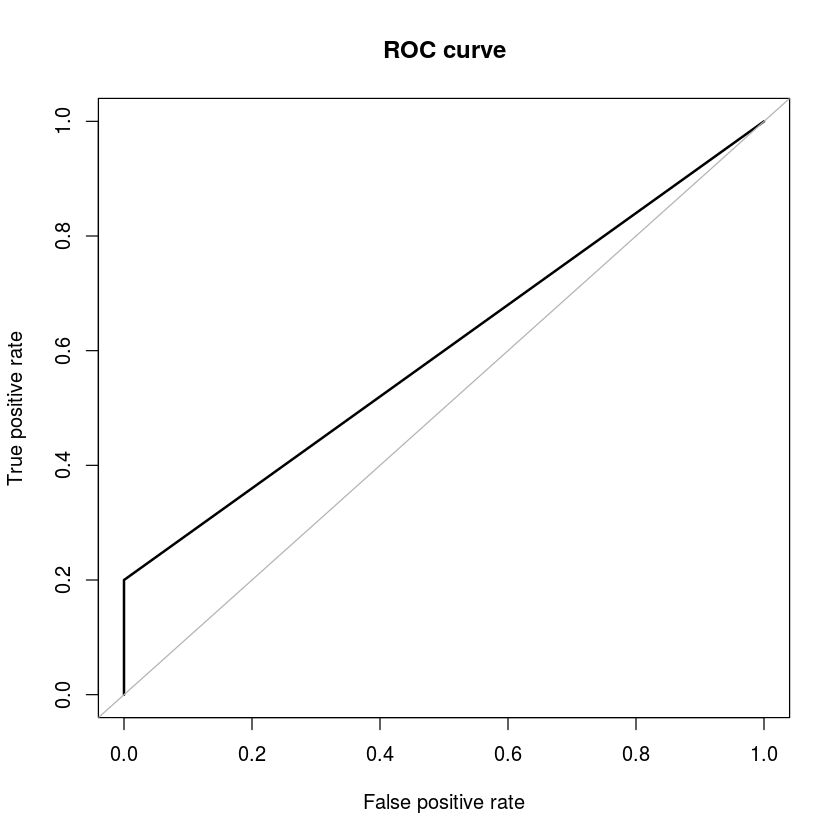

In [32]:
roc.curve(hacide.test$cls, pred.treeimb[,2])

AUC = 0.6. This is a low score. 

Lets try to remedy the situation by using over/under sampling

In [34]:
#Over sampling
data_balanced_over <- ovun.sample(cls~., data = hacide.train, method = "over", N = 1960)$data

In [35]:
table(data_balanced_over$cls)


  0   1 
980 980 

In [36]:
#Under Sampling
data_balanced_under <- ovun.sample(cls~., data=hacide.train, method = "under",
                                   N = 40, seed = 1)$data

In [37]:
table(data_balanced_under$cls)


 0  1 
20 20 

By undersampling we came down to only 20 samples, which is not sufficient to perfrom analysis

In [38]:
data_balanced_both <- ovun.sample(cls~., data=hacide.train, method = "both", p=0.5,
                                 N = 1000, seed=1)$data #p is prob of +ve class

In [39]:
table(data_balanced_both$cls)


  0   1 
520 480 

#### Generating Synthetic data from ROSE

In [40]:
data.rose <- ROSE(cls~., data=hacide.train, seed=1)$data

In [41]:
table(data.rose$cls)


  0   1 
520 480 

Here we have totan N same as per original N

We will now compute accuracy using data sets from all 4 techniques to see which one works the best

In [42]:
tree.rose <- tune.rpart(cls~., data=data.rose, minsplit=c(5,200,5), minbucket=c(5,200,5),
                     maxdepth = c(1,30,2))

In [43]:
summary(tree.rose)


Parameter tuning of ‘rpart.wrapper’:

- sampling method: 10-fold cross validation 

- best parameters:
 minsplit minbucket maxdepth
        5         5       30

- best performance: 0.109 

- Detailed performance results:
   minsplit minbucket maxdepth error dispersion
1         5         5        1 0.206 0.03717825
2       200         5        1 0.206 0.03717825
3         5         5        1 0.206 0.03717825
4         5       200        1 0.206 0.03717825
5       200       200        1 0.206 0.03717825
6         5       200        1 0.206 0.03717825
7         5         5        1 0.206 0.03717825
8       200         5        1 0.206 0.03717825
9         5         5        1 0.206 0.03717825
10        5         5       30 0.109 0.03381321
11      200         5       30 0.109 0.03381321
12        5         5       30 0.109 0.03381321
13        5       200       30 0.206 0.03717825
14      200       200       30 0.206 0.03717825
15        5       200       30 0.206 0.03717825
16       

In [44]:
tree.rosef <- rpart(cls~., data=data.rose, minsplit=5, minbucket=5,maxdepth = 30)

In [45]:
tree.over <- tune.rpart(cls~., data=data_balanced_over, minsplit=c(5,200,5),
                        minbucket=c(5,200,5), maxdepth = c(1,30,2))

In [46]:
summary(tree.over)


Parameter tuning of ‘rpart.wrapper’:

- sampling method: 10-fold cross validation 

- best parameters:
 minsplit minbucket maxdepth
        5         5       30

- best performance: 0.01071429 

- Detailed performance results:
   minsplit minbucket maxdepth      error  dispersion
1         5         5        1 0.14234694 0.025954186
2       200         5        1 0.14234694 0.025954186
3         5         5        1 0.14234694 0.025954186
4         5       200        1 0.14234694 0.025954186
5       200       200        1 0.14234694 0.025954186
6         5       200        1 0.14234694 0.025954186
7         5         5        1 0.14234694 0.025954186
8       200         5        1 0.14234694 0.025954186
9         5         5        1 0.14234694 0.025954186
10        5         5       30 0.01071429 0.006564714
11      200         5       30 0.01071429 0.006564714
12        5         5       30 0.01071429 0.006564714
13        5       200       30 0.14234694 0.025954186
14      200     

In [47]:
tree.overf <- rpart(cls~., data=data_balanced_over, minsplit=5, minbucket=5,maxdepth = 30)

In [48]:
tree.under <- tune.rpart(cls~., data=data_balanced_under, minsplit=c(5,200,5),
                        minbucket=c(5,200,5), maxdepth = c(1,30,2))

In [49]:
summary(tree.under)


Parameter tuning of ‘rpart.wrapper’:

- sampling method: 10-fold cross validation 

- best parameters:
 minsplit minbucket maxdepth
        5         5        1

- best performance: 0.3 

- Detailed performance results:
   minsplit minbucket maxdepth error dispersion
1         5         5        1 0.300  0.1581139
2       200         5        1 0.800  0.1581139
3         5         5        1 0.300  0.1581139
4         5       200        1 0.800  0.1581139
5       200       200        1 0.800  0.1581139
6         5       200        1 0.800  0.1581139
7         5         5        1 0.300  0.1581139
8       200         5        1 0.800  0.1581139
9         5         5        1 0.300  0.1581139
10        5         5       30 0.325  0.2371708
11      200         5       30 0.800  0.1581139
12        5         5       30 0.325  0.2371708
13        5       200       30 0.800  0.1581139
14      200       200       30 0.800  0.1581139
15        5       200       30 0.800  0.1581139
16        5

In [50]:
tree.underf <- rpart(cls~., data=data_balanced_under, minsplit=5, minbucket=5,maxdepth = 1)

In [52]:
tree.both <- tune.rpart(cls~., data=data_balanced_both, minsplit=c(5,200,5),
                        minbucket=c(5,200,5), maxdepth = c(1,30,2))

In [53]:
summary(tree.both)


Parameter tuning of ‘rpart.wrapper’:

- sampling method: 10-fold cross validation 

- best parameters:
 minsplit minbucket maxdepth
        5         5       30

- best performance: 0.006 

- Detailed performance results:
   minsplit minbucket maxdepth error  dispersion
1         5         5        1 0.145 0.027182511
2       200         5        1 0.145 0.027182511
3         5         5        1 0.145 0.027182511
4         5       200        1 0.145 0.027182511
5       200       200        1 0.145 0.027182511
6         5       200        1 0.145 0.027182511
7         5         5        1 0.145 0.027182511
8       200         5        1 0.145 0.027182511
9         5         5        1 0.145 0.027182511
10        5         5       30 0.006 0.006992059
11      200         5       30 0.052 0.022997584
12        5         5       30 0.006 0.006992059
13        5       200       30 0.145 0.027182511
14      200       200       30 0.145 0.027182511
15        5       200       30 0.145 0.027

In [54]:
tree.bothf <- rpart(cls~., data=data_balanced_both, minsplit=5, minbucket=5,maxdepth = 30)

In [55]:
#Make Predictions on test data
pred.tree.rose <- predict(tree.rosef, newdata=hacide.test)
pred.tree.over <- predict(tree.overf, newdata=hacide.test)
pred.tree.under <- predict(tree.underf, newdata=hacide.test)
pred.tree.both <- predict(tree.bothf, newdata=hacide.test)


Checking AUC of all 4 data

Area under the curve (AUC): 0.989

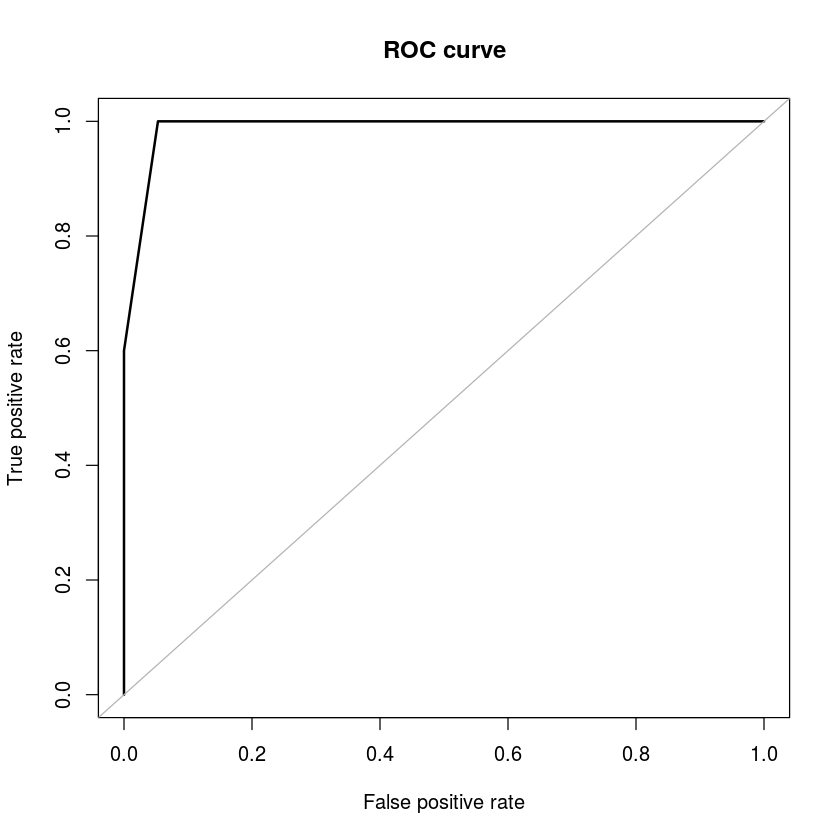

In [56]:
roc.curve(hacide.test$cls, pred.tree.rose[,2])

Area under the curve (AUC): 0.798

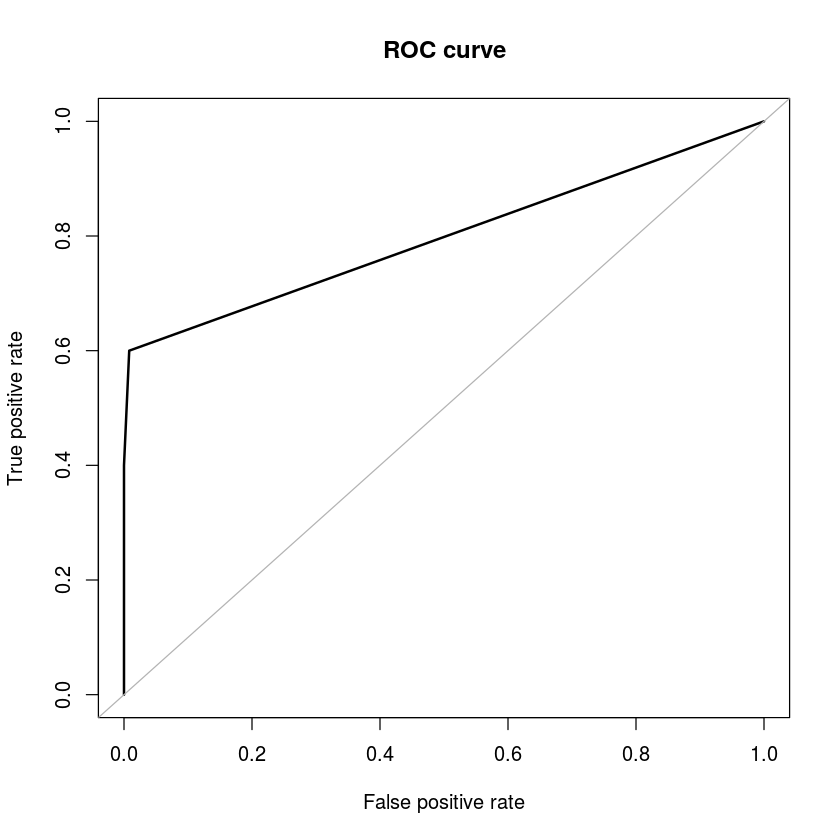

In [57]:
roc.curve(hacide.test$cls, pred.tree.over[,2])

Area under the curve (AUC): 0.867

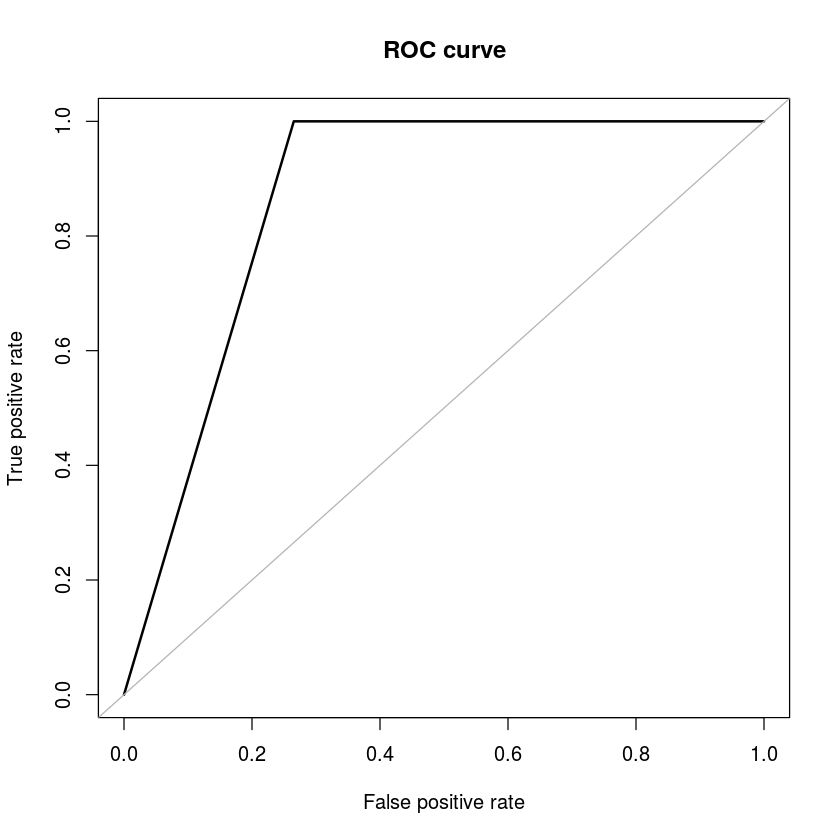

In [58]:
roc.curve(hacide.test$cls, pred.tree.under[,2])

Area under the curve (AUC): 0.798

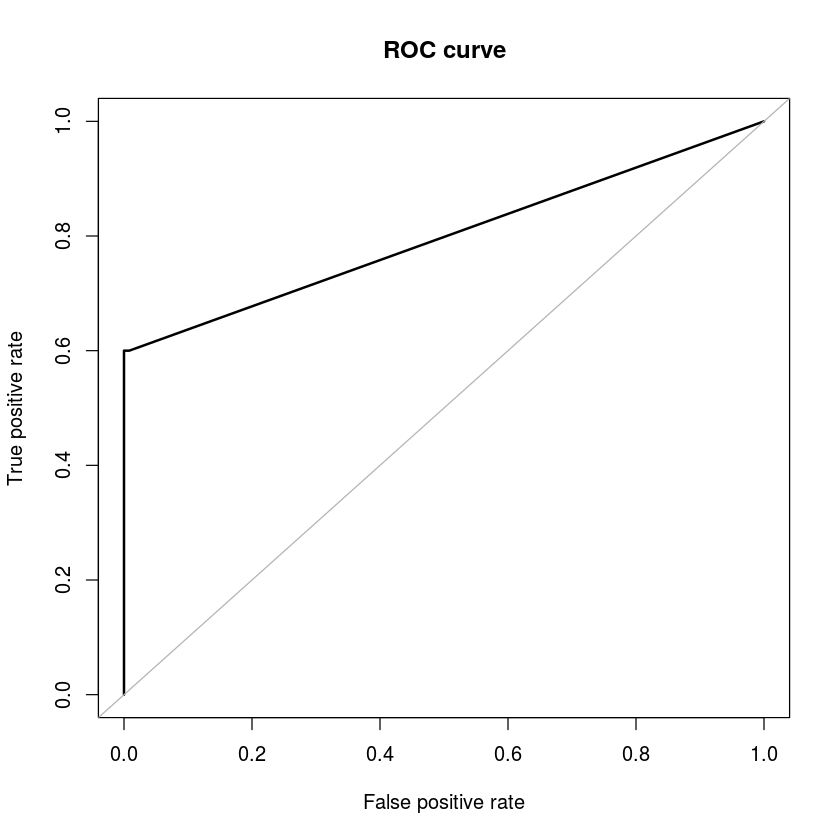

In [59]:
roc.curve(hacide.test$cls, pred.tree.both[,2])

Hence highest ROC was got by using ROSE generated data.